# KNN model to predict the ball's position on the racket using datasets P1, P2, and P3, based on **energy per band features** - Vibration

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the ball's position on the racket(C,S,V) based on sound features extracted from vibration datasets. The workflow involves reading `.csv` files, **extracting energy per frequency band** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through plots of normalized spectrum and band energies.

### Import libraries

In [12]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
import librosa
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
# import openpyxl

### Import Tools Functions

In [13]:
import sys
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Energy

In [14]:
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum

# Main

In [15]:
import ast

# Read the CSV file
df_combined = pd.read_csv("../../../Data/Vibration/All_Data_combinedv3.csv")


df_combined.head()

,Raw Signal Ch0,Spectrum,freqs,File Name,Position,Racket Type,Age
0,[-0.01573961 -0.02470204 -0.0184555 ... -6.36...,"[5415.435319490299, 3187.673624625387, 2567.48...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_1.csv,C,RB,1
1,[ 0.10185837 0.10090781 0.08882211 ... -6.35...,"[3574.0039456266313, 2253.172677296551, 2189.4...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_2.csv,C,RB,1
2,[-0.02701054 -0.01506063 -0.02510942 ... -6.09...,"[4336.317505980091, 2636.183071505374, 2297.29...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_3.csv,C,RB,1
3,[-0.05687327 -0.06352719 -0.05049093 ... -9.29...,"[7218.047965980523, 4371.60331681831, 3234.473...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_S_1.csv,S,RB,1
4,[-0.08674804 -0.04994775 -0.05334261 ... -8.81...,"[6351.72555524914, 3431.4594161592727, 3006.71...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_S_2.csv,S,RB,1


In [16]:
# Compute the feature
freqs = np.array(ast.literal_eval(df_combined["freqs"].iloc[0]))  # Convert string to numpy array

band_energies_list=[]
band_frequencies_list=[]

for spectrum in df_combined["Spectrum"]:
    spectrum_list = np.array(ast.literal_eval(spectrum))  
    band_energies, band_frequencies = energy_per_frequency_band_from_spectrum(spectrum_list, freqs, 20)
    band_energies_list.append(band_energies)
    band_frequencies_list.append(band_frequencies)



df_combined["band_energies"]=band_energies_list
df_combined["band_frequencies"]=band_frequencies_list

In [17]:
# Determine the minimum number of samples for each age group
min_samples_per_age = df_combined['Position'].value_counts().min()

# Create a new DataFrame with equal samples for each age group
df_sorted_homogeneous = (
    df_combined.groupby('Position')
    .apply(lambda x: x.sample(n=min_samples_per_age, random_state=42))
    .reset_index(drop=True)
)

# df_sorted_homogeneous

# Verify the distribution
print(df_sorted_homogeneous['Position'].value_counts())




X = np.array(df_sorted_homogeneous["band_energies"].tolist())

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_sorted_homogeneous["Position"])


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Position
C    72
S    72
V    72
Name: count, dtype: int64


In [18]:
# Définir les bonnes valeurs trouvé
n_neighbors = 10  # Nombre de voisins
weights_options = ['uniform']  # Méthode de pondération
metric_options = ['manhattan']  # Métriques


# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Liste pour stocker les résultats
results = []


# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Ajouter les résultats à la liste
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)

     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean        1.000000       0.954545
1              1   uniform  manhattan        1.000000       0.954545
2              1   uniform  chebyshev        1.000000       0.931818
3              1   uniform  minkowski        1.000000       0.954545
4              1  distance  euclidean        1.000000       0.954545
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski        0.883721       0.886364
156           20  distance  euclidean        1.000000       0.886364
157           20  distance  manhattan        1.000000       0.886364
158           20  distance  chebyshev        1.000000       0.840909
159           20  distance  minkowski        1.000000       0.886364

[160 rows x 5 columns]


## Results and Visualisation

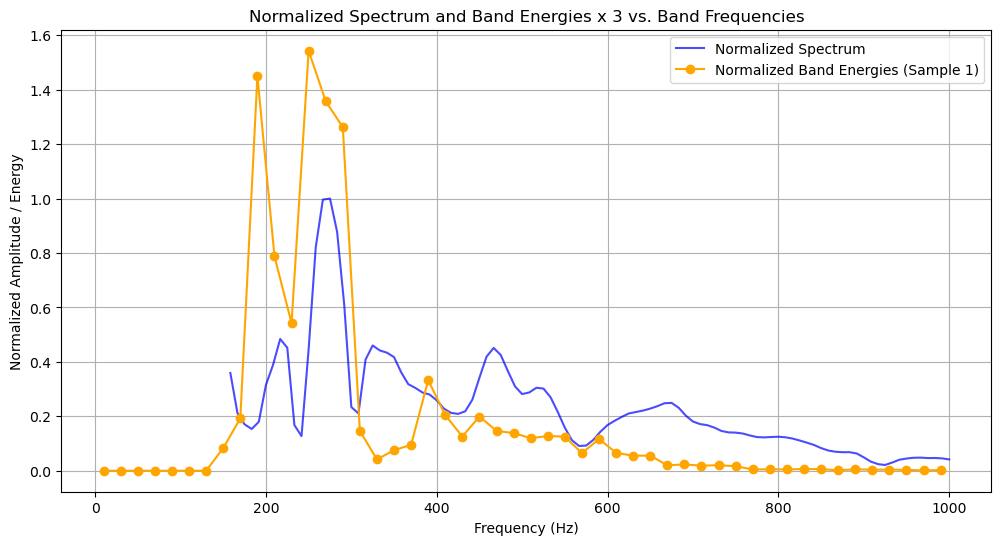

In [19]:
# Extract the spectrum and frequencies of the first entry
spectrum = np.array(ast.literal_eval(df_combined["Spectrum"].iloc[0]))
frequencies = np.array(ast.literal_eval(df_combined["freqs"].iloc[0]))

# Normalize spectrum
spectrum_normalized = spectrum / np.max(spectrum)

# Convert band energies and band frequencies to numpy arrays
band_energies = np.array(df_sorted_homogeneous["band_energies"].tolist())
band_frequencies = np.array(df_sorted_homogeneous["band_frequencies"].tolist())

# Normalize band energies
band_energies_normalized = band_energies / np.max(band_energies)

# Plot the normalized spectrum and band energies vs. band frequencies on the same graph
plt.figure(figsize=(12, 6))

# Plot the normalized spectrum
plt.plot(frequencies, spectrum_normalized, label="Normalized Spectrum", color="blue", alpha=0.7)

# Plot the normalized band energies vs. band frequencies for the first sample
plt.plot(band_frequencies[0], band_energies_normalized[0]*3, label="Normalized Band Energies (Sample 1)", color="orange", marker="o")

plt.title("Normalized Spectrum and Band Energies x 3 vs. Band Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude / Energy")
plt.legend()
plt.grid(True)
plt.show()
